In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
df = pd.read_csv('Tier5_logentries-export-2024-08-20.csv',low_memory = False) 

In [3]:
# Columns to keep
columns_to_keep = ['DateTime', 'ID', 'LogBook ID', 'Latitude', 'Longitude',
                   'Wind Speed/Force', 'Wind Force','Wind Direction', 'Ship Sightings']

# Drop columns except for the ones to keep
df = df[columns_to_keep]

In [5]:
# convert to datetime
df['Entry Date Time'] = pd.to_datetime(df.DateTime, format = '%Y-%m-%d %H:%M:%S')

In [12]:
# creating dataframe of usable data 
df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Ship Sightings"].notna() & df["Wind Force"].notna() & df['Wind Direction'].notna())
df_u = df[df['usable']==True].copy()
df_u

DateTime        ID                     LogBook ID  \
1121    1848-02-25 12:00:00   19878.0       Abigail (ship) 1847-1850   
1244    1848-07-07 12:00:00   20283.0       Abigail (ship) 1847-1850   
1259    1848-07-22 12:00:00   20336.0       Abigail (ship) 1847-1850   
1267    1848-07-30 12:00:00   20372.0       Abigail (ship) 1847-1850   
1269    1848-08-01 12:00:00   20377.0       Abigail (ship) 1847-1850   
...                     ...       ...                            ...   
103685  1839-07-03 12:00:00  107133.0  Young Phenix (ship) 1836-1840   
103711  1839-07-29 12:00:00  107294.0  Young Phenix (ship) 1836-1840   
103712  1839-07-30 12:00:00  107295.0  Young Phenix (ship) 1836-1840   
103789  1839-10-15 12:00:00  107907.0  Young Phenix (ship) 1836-1840   
103822  1839-11-17 12:00:00  108075.0  Young Phenix (ship) 1836-1840   

         Latitude   Longitude Wind Speed/Force  Wind Force  Wind Direction  \
1121   -33.750000  -80.750000     strong winds         6.0           180.0   
1244    31.416667  165.500000      light winds         2.0            90.0   
1259    31.250000  164.833333     strong winds         6.0            90.0   
1267    30.655556  169.488889     strong winds         6.0           180.0   
1269    30.861111  170.827778     strong winds         6.0           180.0   
...           ...         ...              ...         ...             ...   
103685 -18.058333  115.083333    light breezes         2.0            45.0   
103711 -18.183333  115.250000    light breezes         2.0           225.0   
103712 -18.400000  115.625000    light breezes         2.0           270.0   
103789 -13.400000  112.433333    light breezes         2.0           180.0   
103822 -13.200000  113.783333   strong breezes         6.0           135.0   

                                           Ship Sightings     Entry Date Time  \
1121                              "the Emerald came down" 1848-02-25 12:00:00   
1244    "spoke the Old Phenix (Phenix) N Bed Capt McCl... 1848-07-07 12:00:00   
1259    "spoke the ship Howard of Nantuckett Capt Bunk... 1848-07-22 12:00:00   
1267                   "in company with the Narragansett" 1848-07-30 12:00:00   
1269                   "in company with the Narragansett" 1848-08-01 12:00:00   
...                                                   ...                 ...   
103685  "spoke the Resolution (1 small whale) and the ... 1839-07-03 12:00:00   
103711  "spoke the Rodman Capt Dexter 24 months out wi... 1839-07-29 12:00:00   
103712  "spoke the Two Brothers (Capt) Howland 10 mont... 1839-07-30 12:00:00   
103789  "spoke teh Clifford Wayne of Fair Haven 23 mon... 1839-10-15 12:00:00   
103822                   saw the Samuel Enderby of London 1839-11-17 12:00:00   

        usable  
1121      True  
1244      True  
1259      True  
1267      True  
1269      True  
...        ...  
103685    True  
103711    True  
103712    True  
103789    True  
103822    True  

[4669 rows x 11 columns]

In [13]:
# convert values in 'LogBook ID' to strings
ship_id = df_u['LogBook ID'].map(str)
# extract ship names (Capitalized words)
ship_names = ship_id.apply(lambda x : re.findall(r'\b[A-Z][a-z]+\b',x))

In [14]:
# flatten the list of ship names in to a single list
ship_names_flat = [item for sublist in ship_names for item in sublist]
# get unique sdhip names
unique_ships = list(pd.Series(ship_names_flat).unique()) 
# identify common capitalized words in data set that are unlikely to be ship names
stopwords = ['Bark', 'Ship',"St"]
# remove words in 'stopwords'
for word in list(unique_ships):
    if word in stopwords:
        unique_ships.remove(word)

# view unique ships
print(unique_ships)

['Abigail', 'Abraham', 'Barker', 'Addison', 'Adeline', 'Gibbs', 'Alaska', 'Albion', 'Alto', 'American', 'Arab', 'Arbella', 'Atlantic', 'Awashonks', 'Barclay', 'Bartholomew', 'Gosnold', 'Benjamin', 'Rush', 'Bertha', 'Blackstone', 'Brandt', 'Brunswick', 'Cadmus', 'Cambria', 'Catalpa', 'Chariot', 'Charles', 'Drew', 'Phelps', 'Morgan', 'Henry', 'Clarice', 'Clarkson', 'Clifford', 'Wayne', 'Columbia', 'Coronet', 'Courier', 'Courser', 'Draco', 'Eagle', 'Emerald', 'Eunice', 'Adams', 'Brig', 'Fabius', 'Fortune', 'Franklin', 'Gage', 'Phillips', 'Schooner', 'General', 'Jackson', 'George', 'Clinton', 'Gideon', 'Howland', 'Good', 'Return', 'Governor', 'Carver', 'Greyhound', 'Harrison', 'Kneeland', 'Hercules', 'Hibernia', 'Homer', 'Isabella', 'Israel', 'Java', 'John', 'Dawson', 'Lafayette', 'Lancer', 'Leonidas', 'Margaret', 'Maria', 'Martha', 'Mary', 'Frazier', 'Mitchell', 'Matilda', 'Sears', 'Mechanic', 'Medford', 'Mexico', 'Milo', 'Moctezuma', 'Mohawk', 'Montano', 'Navy', 'Nile', 'Ocean', 'Octavia

In [15]:
# identify rows where the 'Ship Sightings' column contains one of the unique ship names identified
df_u.loc[:, 'matches'] = np.where(
    df_u['Ship Sightings'].str.contains('|'.join(unique_ships)), 'match', 'not match')

In [16]:
#Identify matches in "LogBook ID" 
df_u['logbook_match'] = np.where(df_u['LogBook ID'].fillna('').str.contains('|'.join(unique_ships), case=False), 'match', 'not match')

#Identify matches in "Ship Sightings"
df_u['sightings_match'] = np.where(df_u['Ship Sightings'].fillna('').str.contains('|'.join(unique_ships), case=False), 'match', 'not match')


In [19]:
#create two seperate dataframes where both contain match
df_logbook_matches = df_u[df_u['logbook_match'] == 'match'].copy()
df_sightings_matches = df_u[df_u['sightings_match'] == 'match'].copy()

In [20]:
# Create column to track matched ship 
df_logbook_matches.loc[:, 'Matched_Ship'] = df_logbook_matches['LogBook ID'].str.extract('(' + '|'.join(unique_ships) + ')', expand=False)
df_sightings_matches.loc[:, 'Matched_Ship'] = df_sightings_matches['Ship Sightings'].str.extract('(' + '|'.join(unique_ships) + ')', expand=False)

#Merge on the extracted Matched_Ship names to align LogBook and Sightings correctly
df_final = df_logbook_matches.merge(df_sightings_matches, on='Matched_Ship', suffixes=('_1', '_2'))

# Reset index for readability
df_final.reset_index(drop=True, inplace=True)

# Drop rows where Logbook id_1 and Logbook id_2 match 
df_final = df_final[df_final['LogBook ID_1'] != df_final['LogBook ID_2']]

In [22]:
#columns to keep
columns_to_keep = ['ID_1','LogBook ID_1','Latitude_1','Longitude_1','Wind Speed/Force_1',
                   'Wind Force_1','Wind Direction_1','Ship Sightings_1','Entry Date Time_1','Matched_Ship',
                   'ID_2','LogBook ID_2','Latitude_2','Longitude_2','Wind Speed/Force_2','Wind Force_2','Wind Direction_2',
                   'Ship Sightings_2','Entry Date Time_2']
#drop columns except ones to keep
df_final = df_final[columns_to_keep]

In [23]:
from geopy.distance import geodesic

def calculate_distances(df):
    distances = []
    for i in range(len(df)):
        point1 = (df.iloc[i]['Latitude_1'], df.iloc[i]['Longitude_1'])
        point2 = (df.iloc[i]['Latitude_2'], df.iloc[i]['Longitude_2'])
        distance = geodesic(point1, point2).kilometers  # Calculate distance in km
        distances.append(distance)
    return distances



# Apply the function and create a new column for distance
df_final = df_final.assign(Distance_km=calculate_distances(df_final))

In [24]:
# Calculate difference in dates between ships
df_final['Date Difference'] = (df_final['Entry Date Time_1'] - df_final['Entry Date Time_2']).abs()
# Calculate differene in wind force
df_final['Wind Force Difference'] = (df_final['Wind Force_1'] - df_final['Wind Force_2']).abs()
#view Final dataframe
df_final

ID_1                   LogBook ID_1  Latitude_1  Longitude_1  \
0       19878.0       Abigail (ship) 1847-1850      -33.75   -80.750000   
1       19878.0       Abigail (ship) 1847-1850      -33.75   -80.750000   
2       19878.0       Abigail (ship) 1847-1850      -33.75   -80.750000   
3       19878.0       Abigail (ship) 1847-1850      -33.75   -80.750000   
4       19878.0       Abigail (ship) 1847-1850      -33.75   -80.750000   
...         ...                            ...         ...          ...   
79804  108075.0  Young Phenix (ship) 1836-1840      -13.20   113.783333   
79805  108075.0  Young Phenix (ship) 1836-1840      -13.20   113.783333   
79806  108075.0  Young Phenix (ship) 1836-1840      -13.20   113.783333   
79807  108075.0  Young Phenix (ship) 1836-1840      -13.20   113.783333   
79808  108075.0  Young Phenix (ship) 1836-1840      -13.20   113.783333   

      Wind Speed/Force_1  Wind Force_1  Wind Direction_1  \
0           strong winds           6.0             180.0   
1           strong winds           6.0             180.0   
2           strong winds           6.0             180.0   
3           strong winds           6.0             180.0   
4           strong winds           6.0             180.0   
...                  ...           ...               ...   
79804     strong breezes           6.0             135.0   
79805     strong breezes           6.0             135.0   
79806     strong breezes           6.0             135.0   
79807     strong breezes           6.0             135.0   
79808     strong breezes           6.0             135.0   

                       Ship Sightings_1   Entry Date Time_1 Matched_Ship  ...  \
0               "the Emerald came down" 1848-02-25 12:00:00      Abigail  ...   
1               "the Emerald came down" 1848-02-25 12:00:00      Abigail  ...   
2               "the Emerald came down" 1848-02-25 12:00:00      Abigail  ...   
3               "the Emerald came down" 1848-02-25 12:00:00      Abigail  ...   
4               "the Emerald came down" 1848-02-25 12:00:00      Abigail  ...   
...                                 ...                 ...          ...  ...   
79804  saw the Samuel Enderby of London 1839-11-17 12:00:00        Young  ...   
79805  saw the Samuel Enderby of London 1839-11-17 12:00:00        Young  ...   
79806  saw the Samuel Enderby of London 1839-11-17 12:00:00        Young  ...   
79807  saw the Samuel Enderby of London 1839-11-17 12:00:00        Young  ...   
79808  saw the Samuel Enderby of London 1839-11-17 12:00:00        Young  ...   

       Latitude_2 Longitude_2  Wind Speed/Force_2  Wind Force_2  \
0       64.145238 -173.450000      strong breezes           6.0   
1       55.816667  142.000000       fresh breezes           5.0   
2       54.533333  145.133333       fresh breezes           5.0   
3       -7.666667  -87.000000       fresh breezes           5.0   
4       -8.633333  -88.000000       fresh breezes           5.0   
...           ...         ...                 ...           ...   
79804  -23.725000   49.666667      strong breezes           6.0   
79805   32.166667  163.000000    moderate breezes           4.0   
79806   29.533333  162.000000        strong winds           6.0   
79807   30.166667  162.000000       light breezes           2.0   
79808   12.750000  -45.200000       fresh breezes           5.0   

      Wind Direction_2                                   Ship Sightings_2  \
0                 45.0                                   Saratoga Abigail   
1                315.0                         The Abigail of New Bedford   
2                 45.0             Spoke with Bark Abigail of New Bedford   
3                135.0  "spoke the ship Abigail (of Nantucket) Capt Cl...   
4                157.5                             "the Abigail in sight"   
...                ...                                                ...   
79804             90.0         Spoke with "Young Phoenix" 2 sails sighte

In [25]:
# filter by distance and date
df_200= df_final.loc[(df_final['Distance_km'] <= 200) & (df_final['Date Difference'] <= pd.Timedelta(days=0))]

In [26]:
#reset index
df_200 = df_200.reset_index(drop = True)

In [27]:
# calculate angular difference between wind directiond
def angular_diff(deg1, deg2):
    return abs((deg1 - deg2 + 180) % 360 - 180)

# apply function to create 'Wind Direction Difference'
df_200['Wind Direction Diff'] = df_200.apply(lambda row: angular_diff(row['Wind Direction_1'], row['Wind Direction_2']), axis=1)

df_200

ID_1                     LogBook ID_1  Latitude_1  Longitude_1  \
0    74537.0          Bertha (Bark) 1878-1881   29.400000   -52.366667   
1    74538.0          Bertha (Bark) 1878-1881   29.316667   -52.216667   
2    74539.0          Bertha (Bark) 1878-1881   29.616667   -52.366667   
3    65995.0       Brunswick (ship) 1834-1837  -23.383333    36.183333   
4    55613.0         Courier (ship) 1834-1836  -23.383333    36.750000   
5    71412.0         Fortune (Bark) 1850-1854   60.933333   179.194444   
6    89314.0          George (ship) 1836-1837  -56.850000   -63.500000   
7    78385.0        Harrison (Ship) 1850-1854   60.866667  -179.722222   
8    56684.0  Henry Kneeland (ship) 1848-1851   28.600000  -157.200000   
9    37085.0        Mechanic (Ship) 1846-1851   19.950000   134.675000   
10   39013.0        Mechanic (Ship) 1846-1851   28.500000  -157.050000   
11  102258.0            Navy (Ship) 1851-1855   68.450000  -171.333333   
12   79671.0            Nile (ship) 1835-1837  -56.883333   -63.850000   
13   30810.0        Orozimbo (Ship) 1845-1848   52.133333  -154.700000   
14   66080.0                     Perry (Bark)   29.416667   -52.783333   
15   66081.0                     Perry (Bark)   29.650000   -52.608333   
16   66082.0                     Perry (Bark)   29.883333   -52.433333   
17   46815.0        Splendid (Ship) 1846-1849   19.950000   135.500000   
18   46827.0        Splendid (Ship) 1846-1849   29.733333   126.500000   
19   28963.0        Vineyard (Ship) 1844-1847   52.366667  -152.216667   

   Wind Speed/Force_1  Wind Force_1  Wind Direction_1  \
0       light breezes           2.0            180.00   
1       light breezes           2.0            180.00   
2         light winds           2.0            225.00   
3              a gale           8.0            225.00   
4         fresh gales           8.0            180.00   
5      strong breezes           6.0              0.00   
6        fine breezes           5.0             45.00   
7    moderate breezes           4.0             45.00   
8       light breezes           2.0             67.50   
9       light breezes           2.0              0.00   
10     moderate winds           4.0            135.00   
11      fresh breezes           5.0            146.25   
12        brisk winds           5.0             22.50   
13        light winds           2.0              0.00   
14         light airs           1.0            135.00   
15      light breezes           2.0             90.00   
16      light breezes           2.0            315.00   
17      light breezes           2.0            337.50   
18   moderate breezes           4.0            135.00   
19        light winds           2.0              0.00   

                                     Ship Sightings_1   Entry Date Time_1  \
0                                 Bark Perry in sight 1879-06-16 12:00:00   
1                                 Bark Perry in sight 1879-06-17 12:00:00   
2                                 Bark Perry in sight 1879-06-18 12:00:00   
3                      "in company with ship Courier" 1835-04-27 12:00:00   
4                              "Brunswick in company" 1835-04-27 12:00:00   
5                             Harrison of New Bedford 1851-07-09 12:00:00   
6   "spoke the ship Nile of New Bedford 14 months ... 1836-11-02 12:00:00   
7                          The Fortune of New Bedford 1851-07-09 12:00:00   
8                                            Mechanic 1850-10-06 12:00:00   
9                               Splendid of Edgartown 1848-03-25 12:00:00   
10                      Henry Kneeland of New Bedford 1850-10-06 12:00:00   
11                          The South Boston The Milo 1852-09-05 12:00:00   
12  "spoke the ship George Howland 5 months out wi... 1836-11-02 12:00:00   
13        Cabinet of Stonington Vineyard of Edgartown 1846-06-16 12:00:00   
14                               Bark Bertha in sight 1879-06-16 12:00:00   
15                     

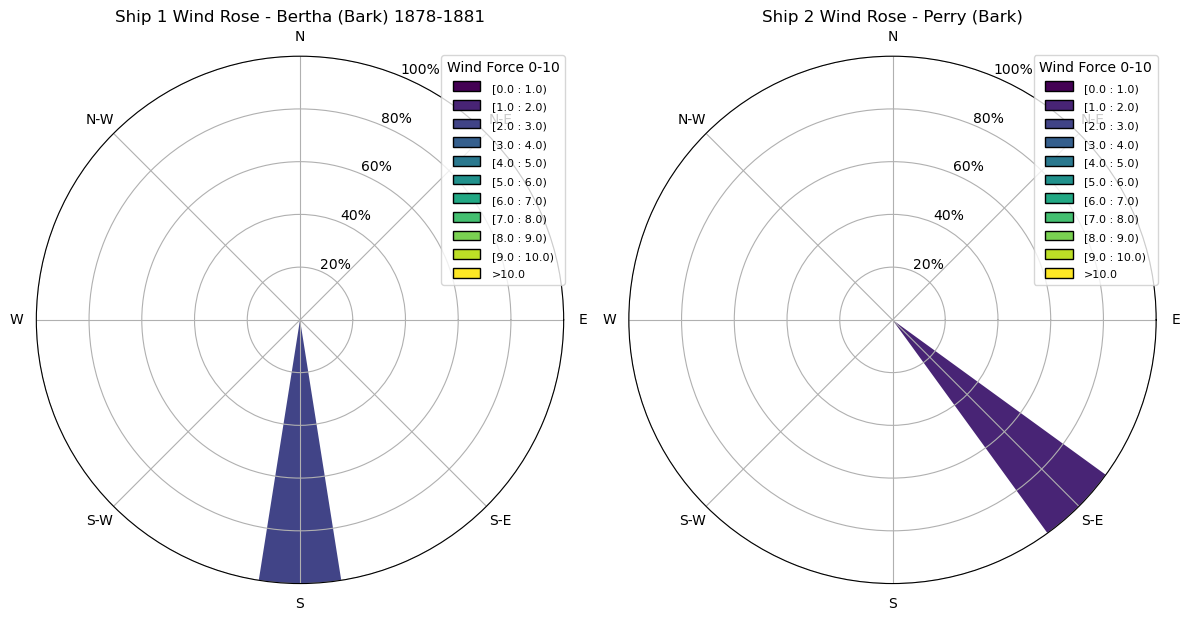

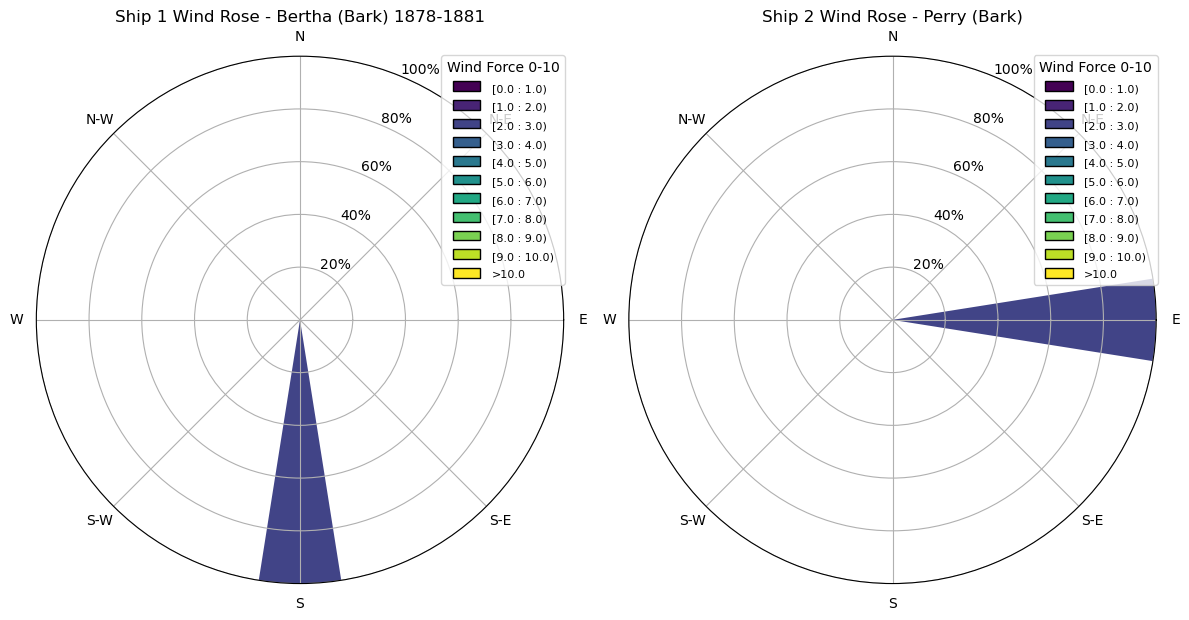

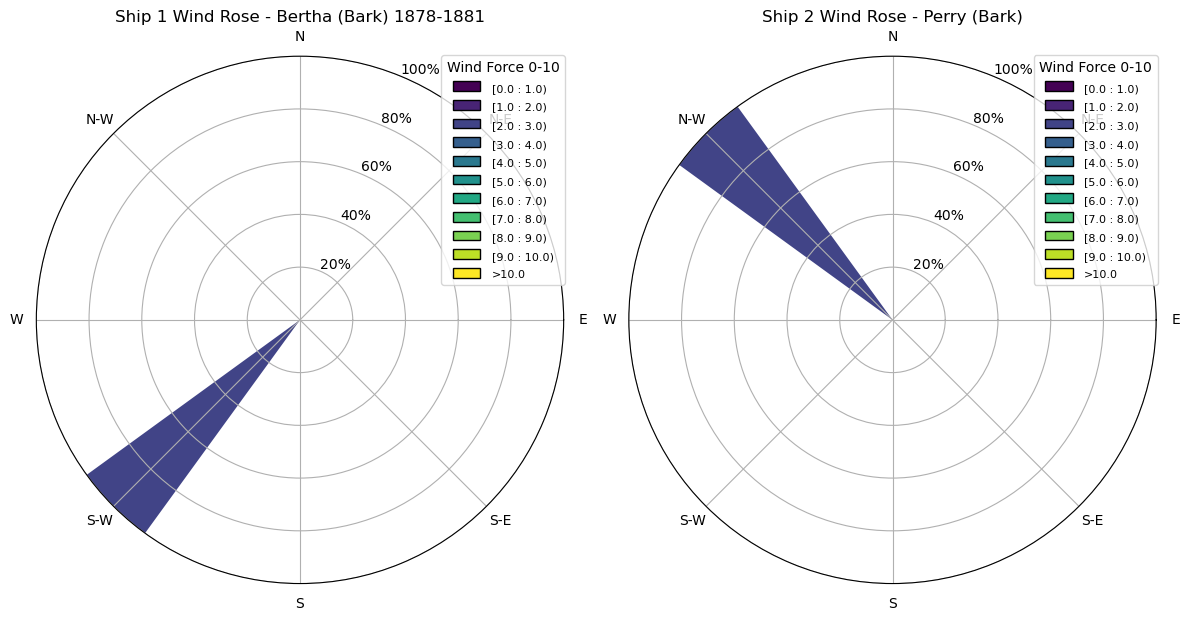

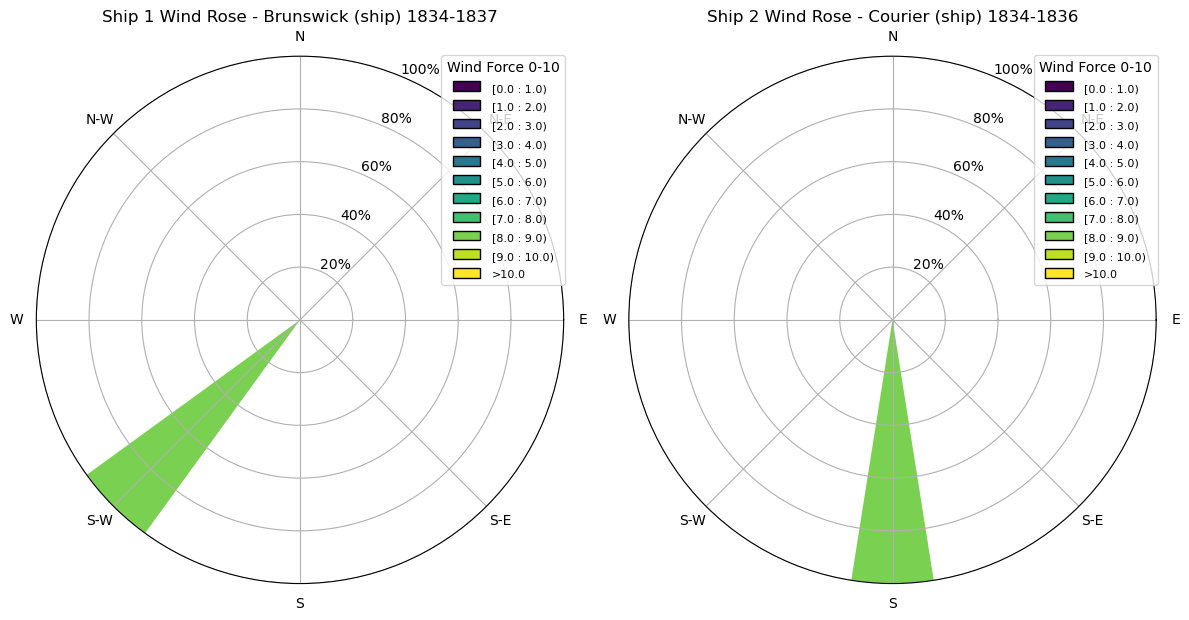

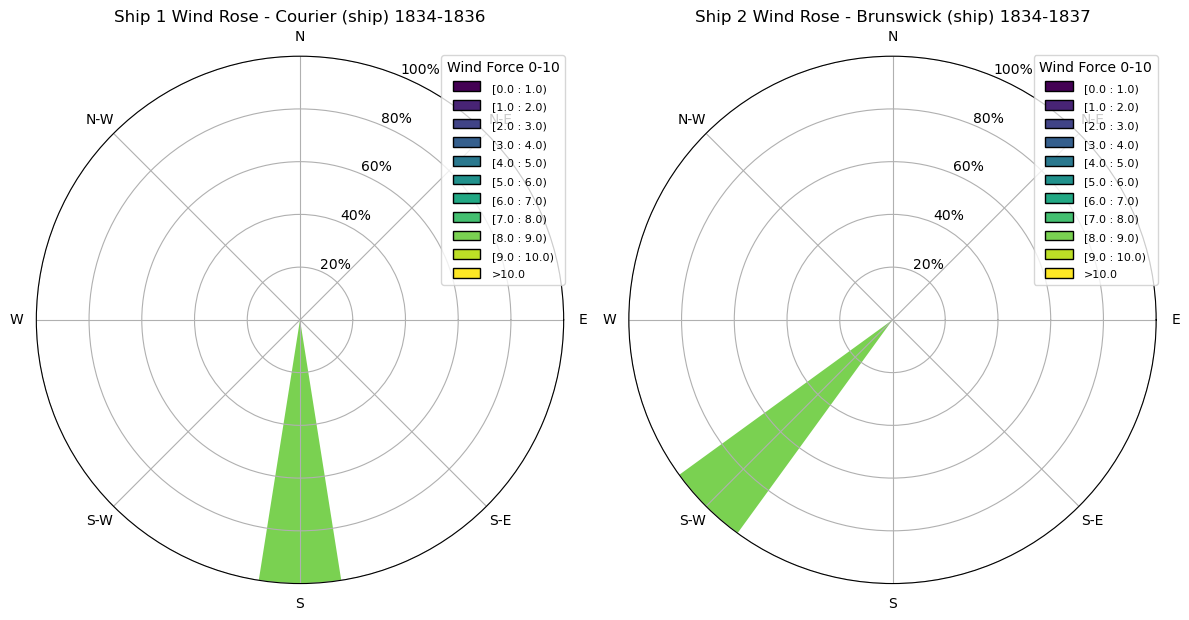

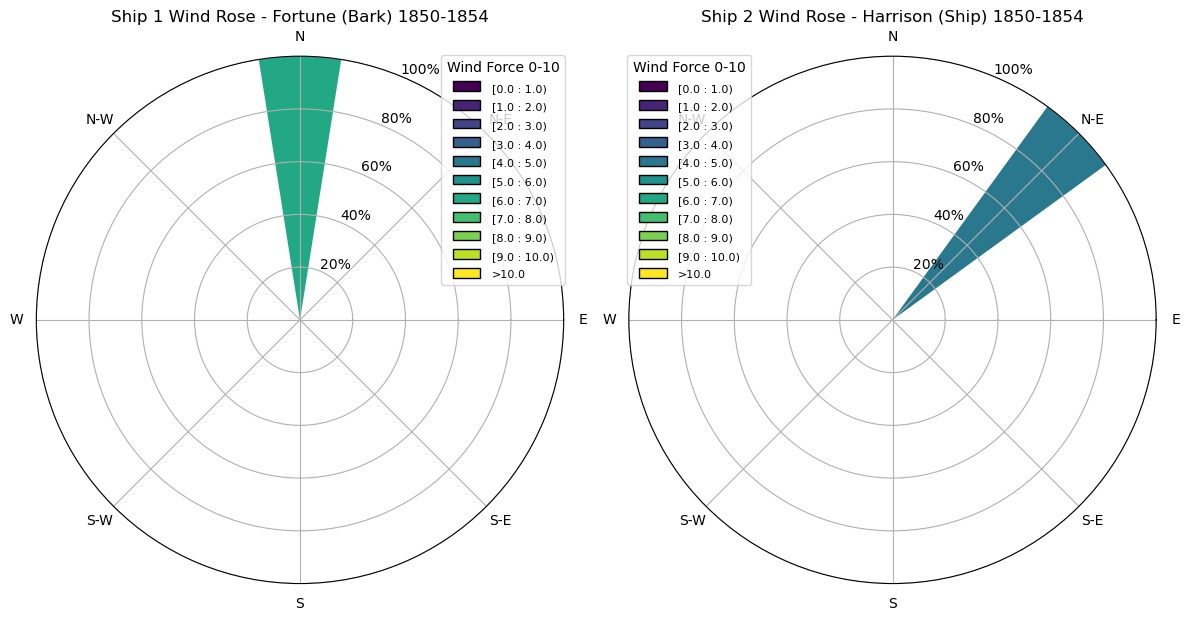

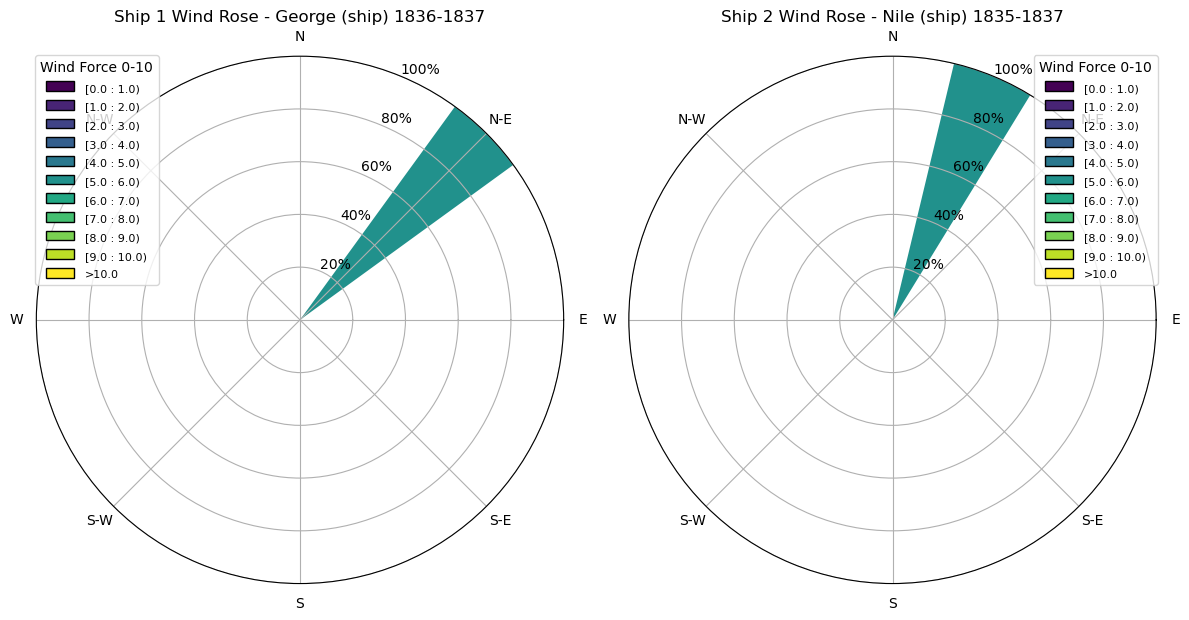

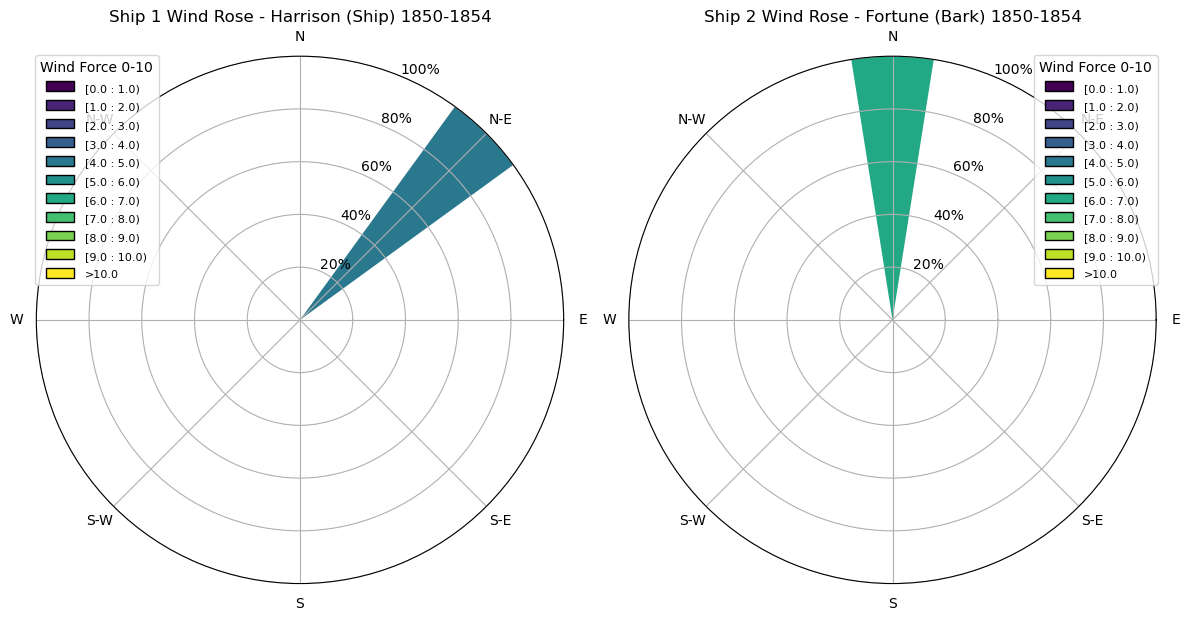

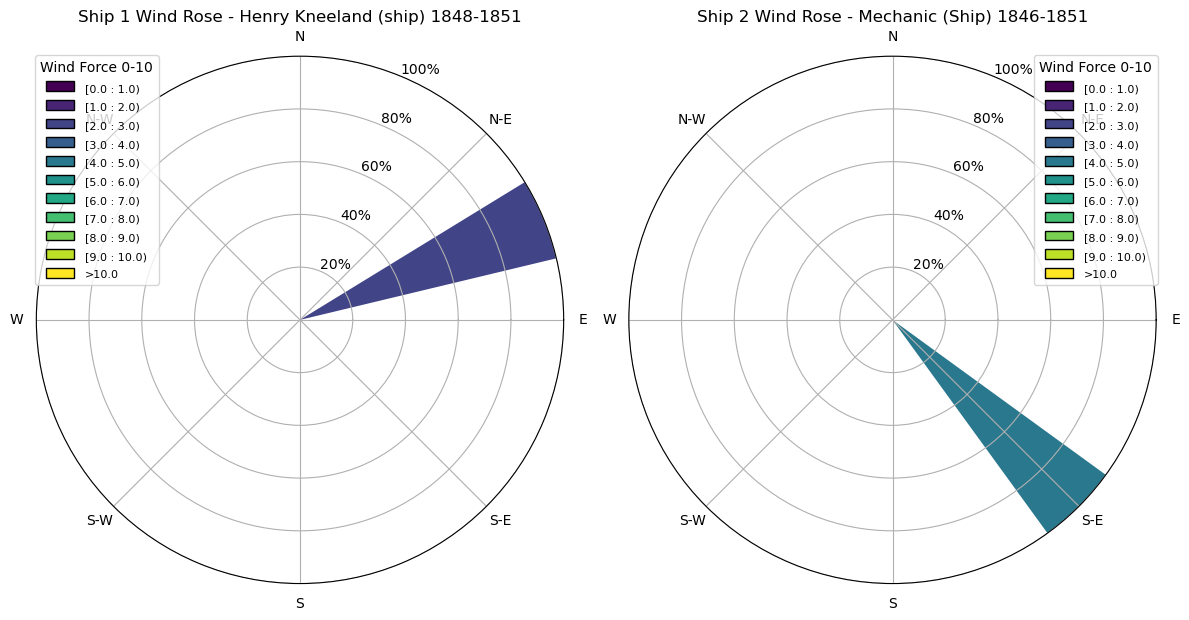

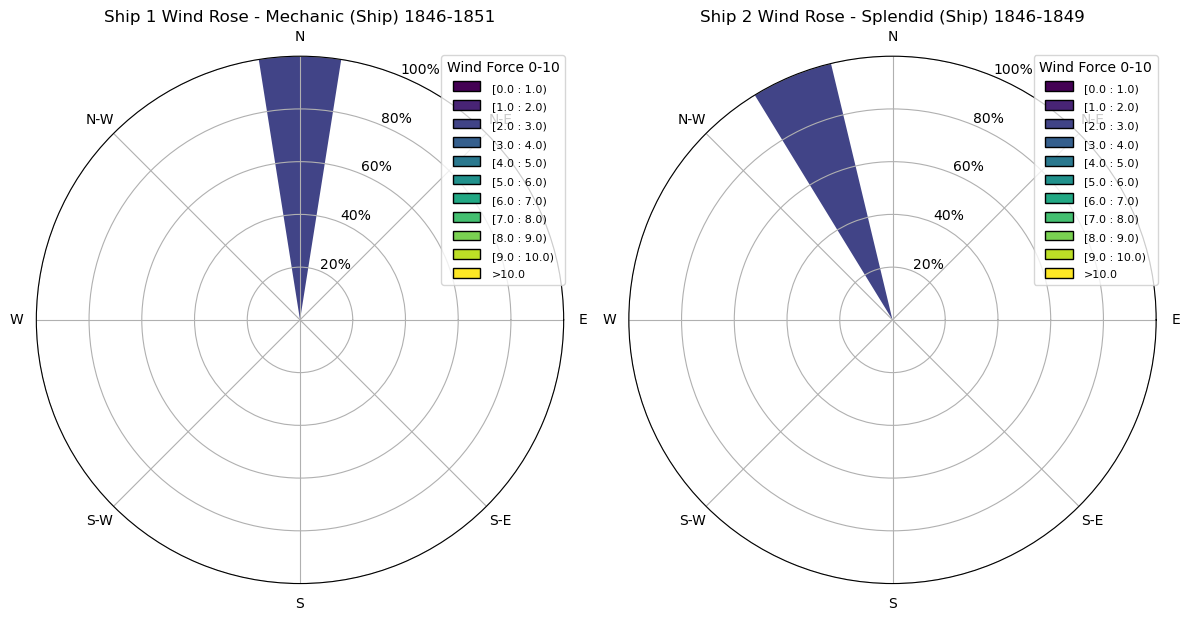

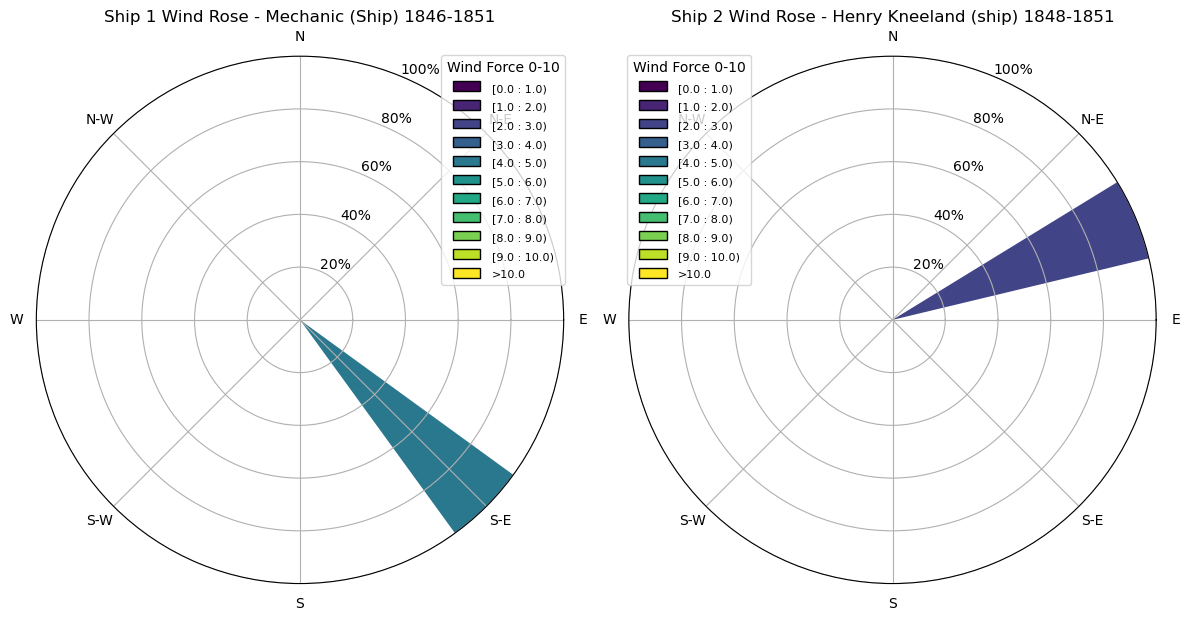

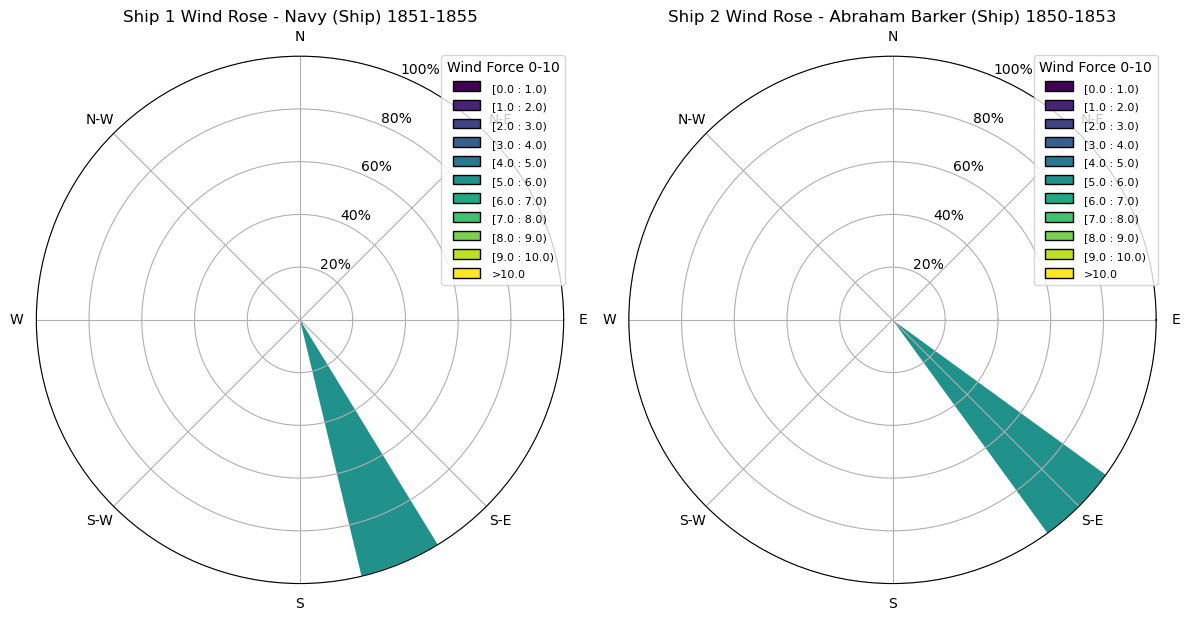

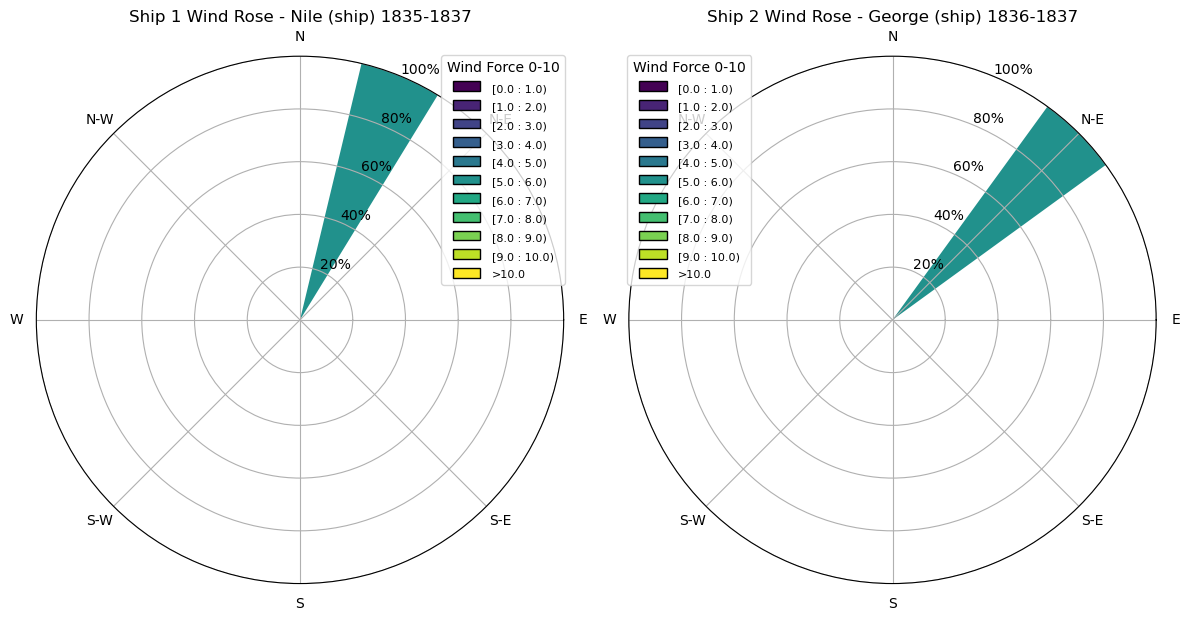

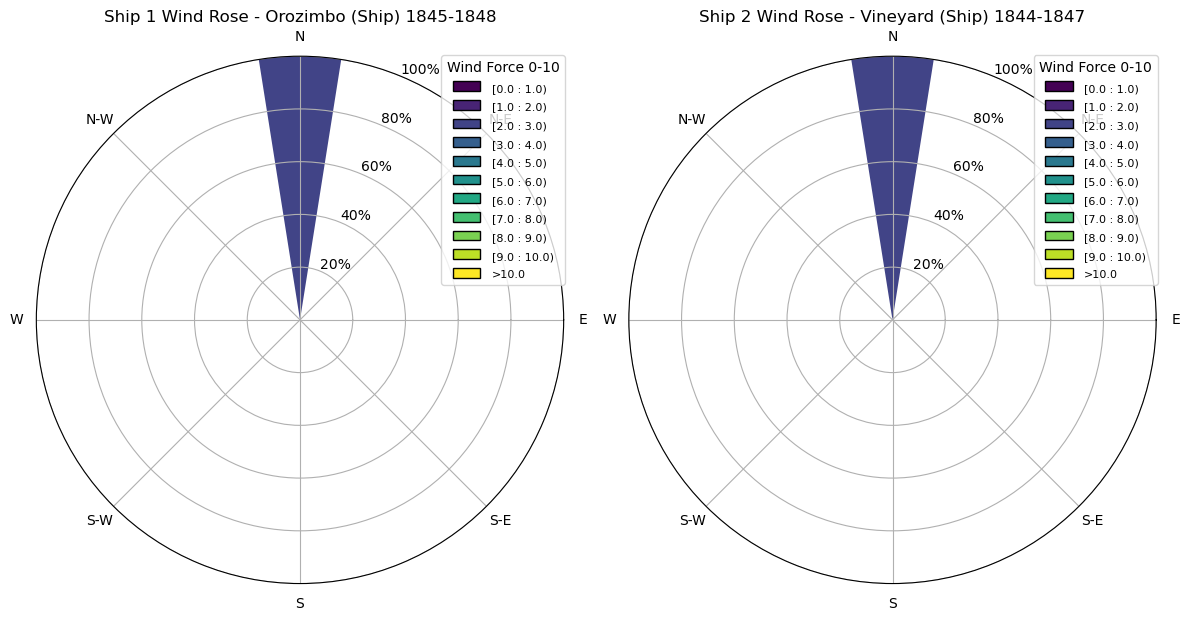

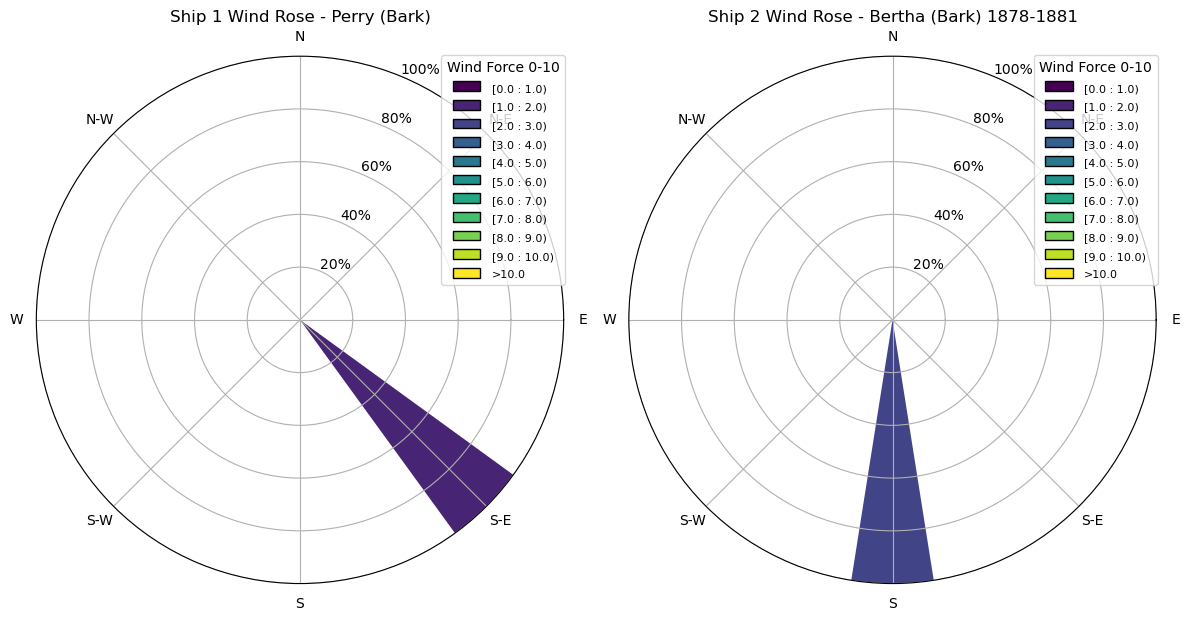

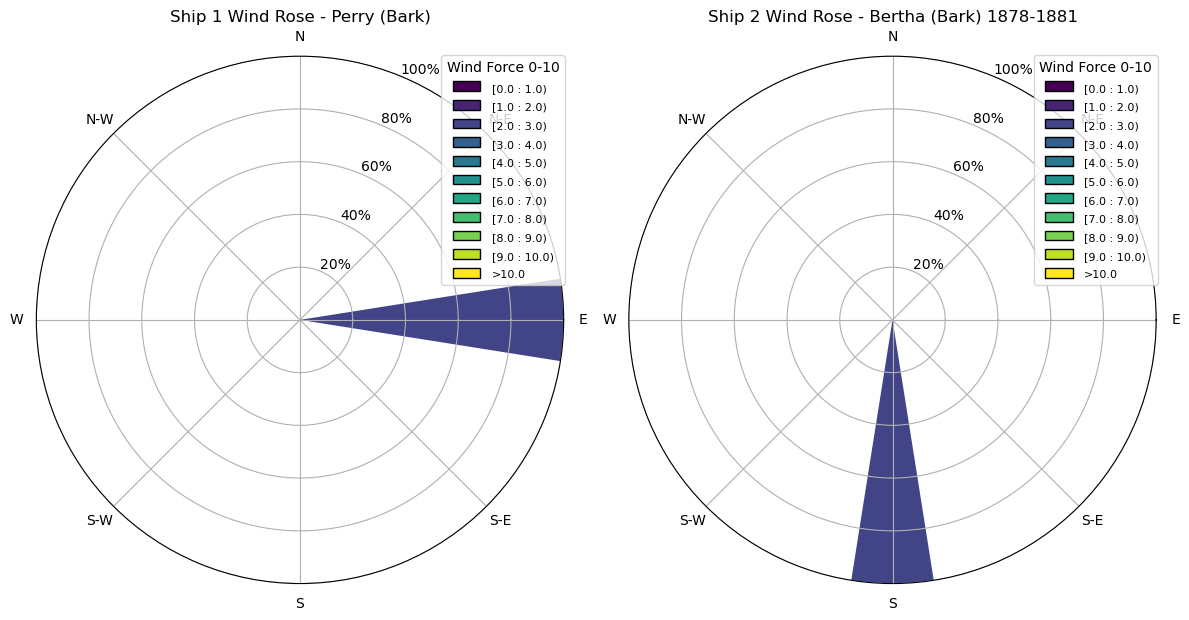

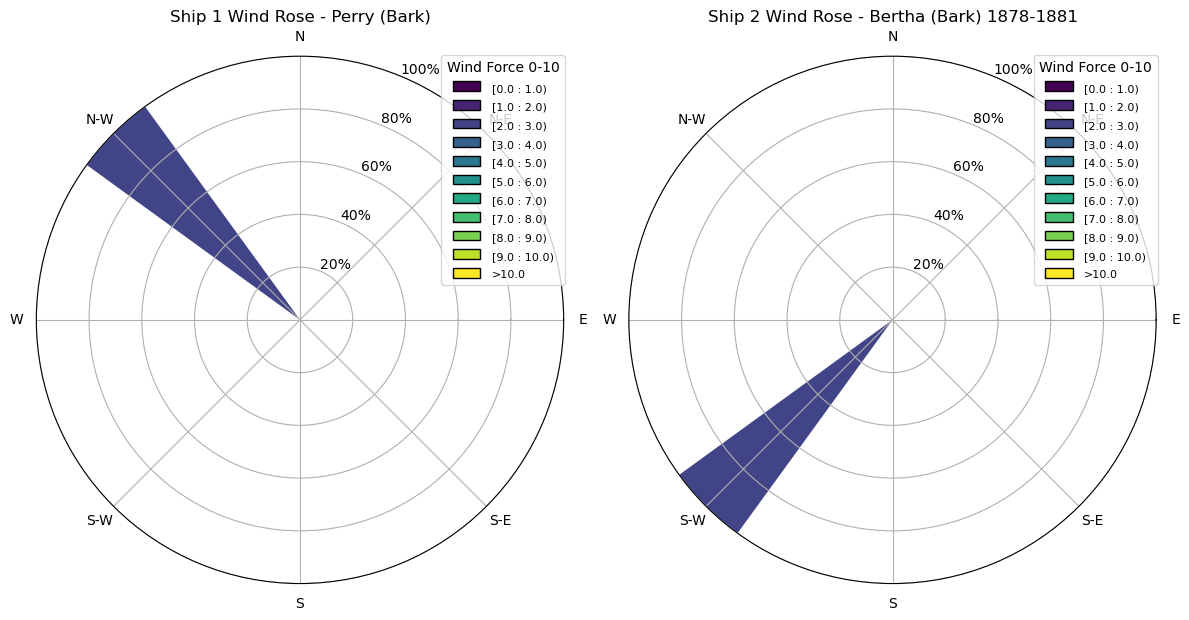

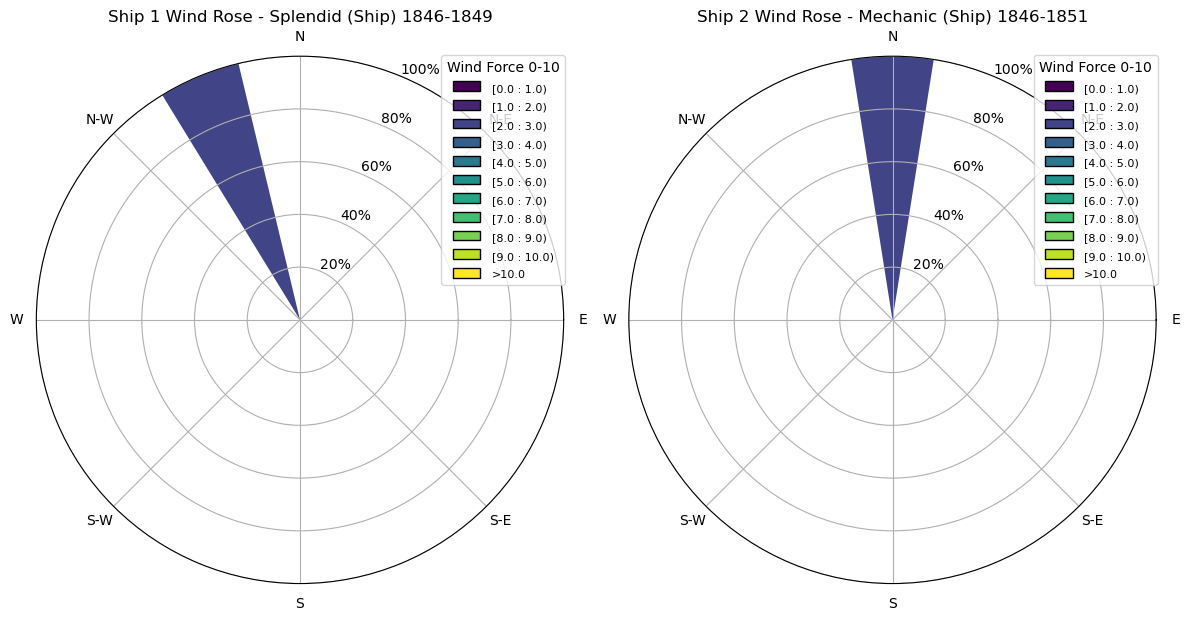

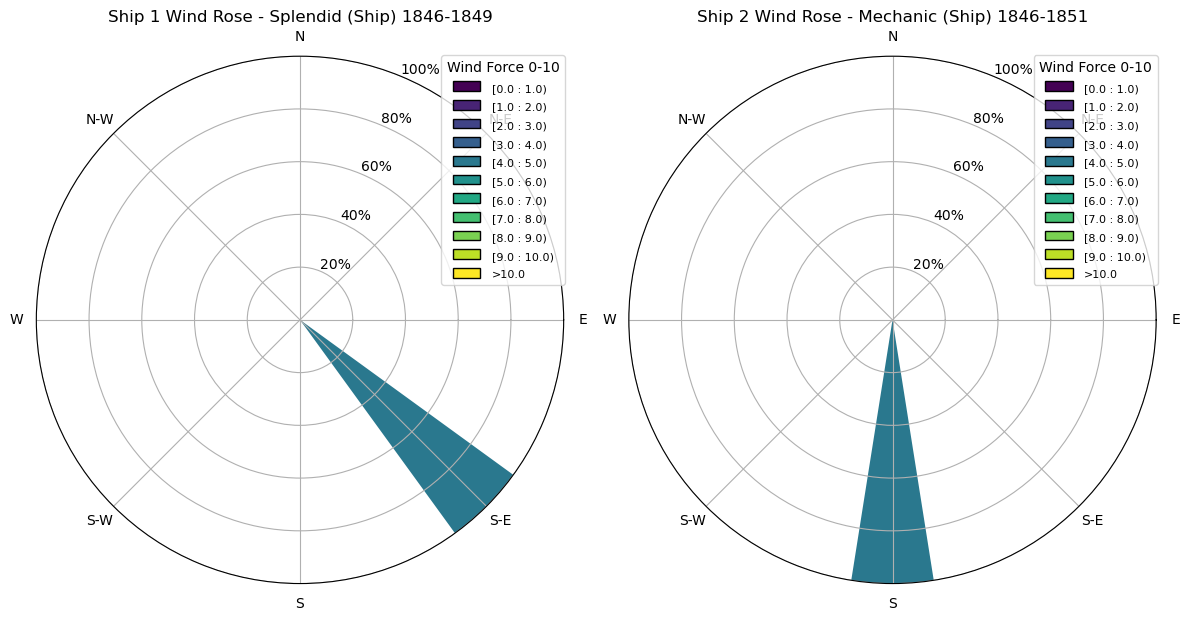

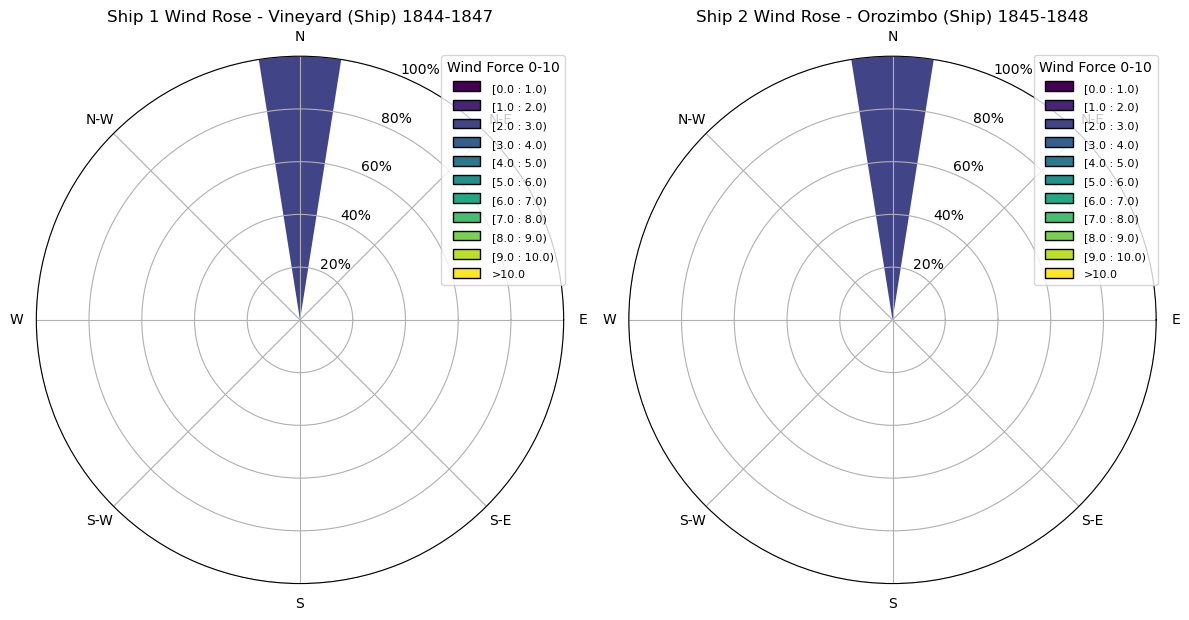

In [28]:
# for loop to display pairs of wind roses
for i, row in df_200.iterrows():

    logbook_id1 = row['LogBook ID_1']
    logbook_id2 = row['LogBook ID_2']
    # Extract wind data for Ship 1 (Left plot)
    wd1 = np.array([row['Wind Direction_1']])  # Wind direction (ensure array)
    ws1 = np.array([row['Wind Force_1']])      # Wind force (ensure array)
    
    # Extract wind data for Ship 2 (Right plot)
    wd2 = np.array([row['Wind Direction_2']])  # Wind direction (ensure array)
    ws2 = np.array([row['Wind Force_2']])      # Wind force (ensure array)

    # Create a figure with 2 subplots
    fig = plt.figure(figsize=(12, 6))

    # Create Windrose Plot for Ship 1 (Left)
    ax1 = fig.add_subplot(121, projection="windrose")  # Use correct windrose projection
    ax1.bar(wd1, ws1, bins=np.arange(0, 11), normed=True)

    # Format the Y-axis as percentages
    fmt = '%.0f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax1.yaxis.set_major_formatter(yticks)

    ax1.set_legend(title='Wind Force 0-10', loc='best')
    ax1.set_title(f'Ship 1 Wind Rose - {logbook_id1}')

    # Create Windrose Plot for Ship 2 (Right)
    ax2 = fig.add_subplot(122, projection="windrose")  # Use correct windrose projection
    ax2.bar(wd2, ws2, bins=np.arange(0, 11), normed=True)

    ax2.yaxis.set_major_formatter(yticks)
    ax2.set_legend(title='Wind Force 0-10', loc='best')
    ax2.set_title(f'Ship 2 Wind Rose - {logbook_id2}')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

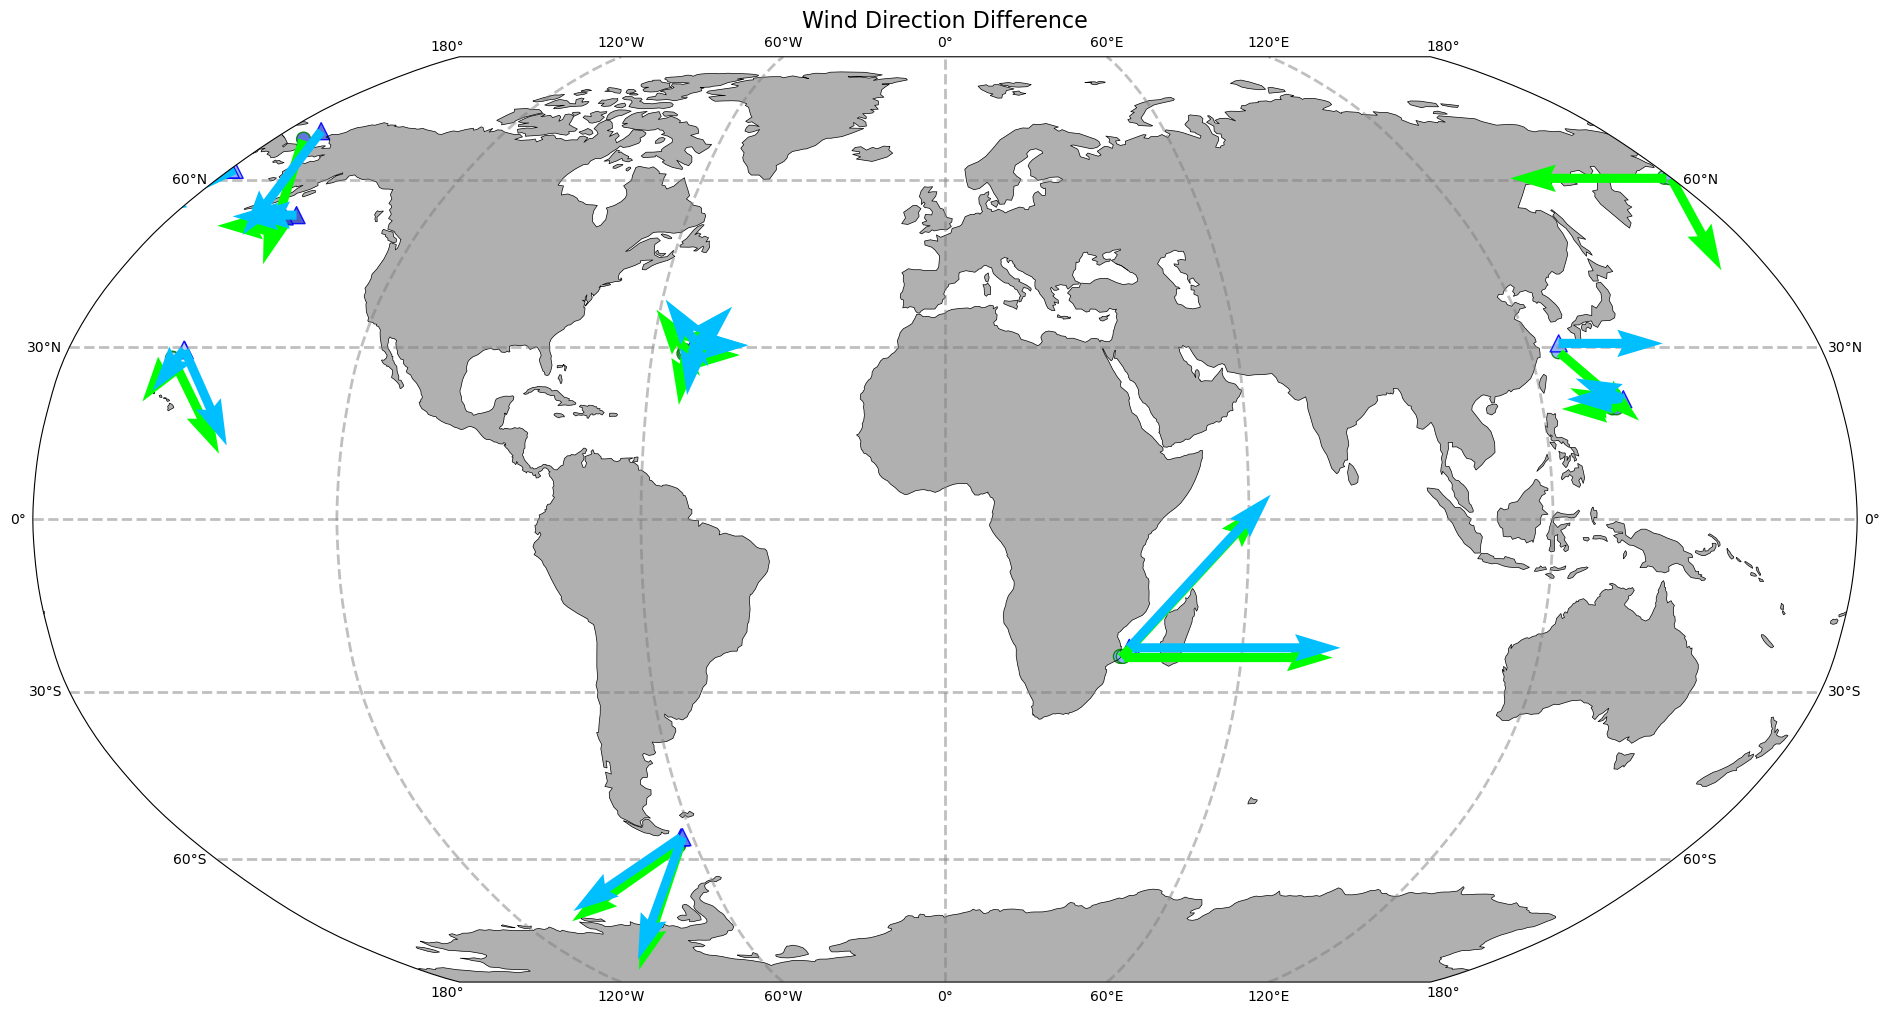

In [38]:

# Step 1: Convert wind direction to "to" vector
df_200['u1'] = np.cos(np.radians(df_200['Wind Direction_1'] + 180)) * df_200['Wind Force_1']
df_200['v1'] = np.sin(np.radians(df_200['Wind Direction_1'] + 180)) * df_200['Wind Force_1']

df_200['u2'] = np.cos(np.radians(df_200['Wind Direction_2'] + 180)) * df_200['Wind Force_2']
df_200['v2'] = np.sin(np.radians(df_200['Wind Direction_2'] + 180)) * df_200['Wind Force_2']

# Step 2: Plot with scaled arrows
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
ax.set_global()
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')

norm = mcolors.Normalize(vmin=0, vmax=180)

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Scatter points
sc1 = ax.scatter(df_200['Longitude_1'] - 0.7, df_200['Latitude_1'] - 0.5,
                 c=df_200['Wind Direction Diff'], cmap='coolwarm', norm=norm,
                 marker='o', s=100, edgecolor='green', label='Ship 1',
                 alpha=0.9, transform=ccrs.PlateCarree())

sc2 = ax.scatter(df_200['Longitude_2'] + 1, df_200['Latitude_2'] + 1,
                 c=df_200['Wind Direction Diff'], cmap='coolwarm', norm=norm,
                 marker='^', s=150, edgecolor='blue', label='Ship 2',
                 alpha=0.9, transform=ccrs.PlateCarree())


# Actual arrows (color, thinner, on top)
ax.quiver(df_200['Longitude_1'] - 0.5, df_200['Latitude_1'] - 0.7,
          df_200['u1'], df_200['v1'],
          transform=ccrs.PlateCarree(), color='#00ff00', scale=70, width=0.005, zorder=2)

ax.quiver(df_200['Longitude_2'] + 1, df_200['Latitude_2'] + 1,
          df_200['u2'], df_200['v2'],
          transform=ccrs.PlateCarree(), color='#00bfff', scale=70, width=0.005, zorder=2)

# Title and colorbar
plt.title("Wind Direction Difference", fontsize=16)
cbar.set_ticks([0, 30, 60, 90, 120, 150, 180])

plt.tight_layout()
plt.savefig('WindDirectionDiff_ScaledArrows')
plt.show()
